In [ ]:
!pip install pystan==2.19.1.1

In [ ]:
!pip install prophet

     |████████████████████████████████| 65 kB 2.8 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6641573 sha256=6c39e21738f8353bdf22217e23d6679c1b06246a426c70943a01da3b75f98497
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 4.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Part I) Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from numpy import sqrt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part II) Import Dataset

In [ ]:
datas = pd.read_csv('/content/drive/MyDrive/Avocado/avocado.csv')
datas = datas.iloc[:, 1:]

# Part III) Select Region

In [ ]:
C = datas.query('region == "California"')
C['Date'] = C['Date'].str[:-3]
C


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
312,2015-12,0.90,5040365.47,1833946.59,1760956.02,232755.85,1212707.01,1090140.07,110737.35,11829.59,conventional,2015,California
313,2015-12,0.94,4695737.21,1676601.43,1543280.76,266689.82,1209165.20,1061703.58,136747.10,10714.52,conventional,2015,California
314,2015-12,0.87,5259354.30,1806690.08,1627240.76,232985.13,1592438.33,1404012.00,180150.37,8275.96,conventional,2015,California
315,2015-12,0.78,5775536.27,1943065.50,2100246.17,221957.26,1510267.34,1376640.91,126664.37,6962.06,conventional,2015,California
316,2015-11,0.91,4575710.62,1461699.38,1810202.70,222311.07,1081497.47,991568.84,82338.39,7590.24,conventional,2015,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17680,2018-02,1.56,188212.98,38078.53,60551.97,0.00,89582.48,89527.66,54.82,0.00,organic,2018,California
17681,2018-01,1.87,170998.81,30070.62,58357.89,0.00,82570.30,82563.11,7.19,0.00,organic,2018,California
17682,2018-01,1.69,181974.98,34411.37,64513.67,0.00,83049.94,83022.84,27.10,0.00,organic,2018,California
17683,2018-01,1.61,216681.04,52253.40,95353.95,0.00,69073.69,69054.51,19.18,0.00,organic,2018,California


# Part IV) Select type

In [ ]:
C_con = C.query('type == "conventional"')
C_con

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
312,2015-12,0.90,5040365.47,1833946.59,1760956.02,232755.85,1212707.01,1090140.07,110737.35,11829.59,conventional,2015,California
313,2015-12,0.94,4695737.21,1676601.43,1543280.76,266689.82,1209165.20,1061703.58,136747.10,10714.52,conventional,2015,California
314,2015-12,0.87,5259354.30,1806690.08,1627240.76,232985.13,1592438.33,1404012.00,180150.37,8275.96,conventional,2015,California
315,2015-12,0.78,5775536.27,1943065.50,2100246.17,221957.26,1510267.34,1376640.91,126664.37,6962.06,conventional,2015,California
316,2015-11,0.91,4575710.62,1461699.38,1810202.70,222311.07,1081497.47,991568.84,82338.39,7590.24,conventional,2015,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8557,2018-02,0.80,10894677.77,4473811.63,4097591.67,146357.78,2176916.69,2072477.62,34196.27,70242.80,conventional,2018,California
8558,2018-01,1.16,6134040.58,2254631.80,2185495.65,121090.87,1572822.26,1480527.70,24545.94,67748.62,conventional,2018,California
8559,2018-01,1.12,6610010.64,2378177.09,2590301.70,122950.68,1518581.17,1431898.88,24801.59,61880.70,conventional,2018,California
8560,2018-01,1.27,5927016.73,2098762.55,2356359.93,151045.33,1320848.92,1226559.09,25390.97,68898.86,conventional,2018,California


In [ ]:
C_org = C.query('type == "organic"')
C_org

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
9438,2015-12,1.45,98576.63,14306.68,50893.97,0.00,33375.98,29507.45,3868.53,0.0,organic,2015,California
9439,2015-12,1.35,99793.55,12746.47,48195.95,1.52,38849.61,25535.80,13313.81,0.0,organic,2015,California
9440,2015-12,1.39,98605.40,13609.24,46518.56,3.05,38474.55,24359.79,14114.76,0.0,organic,2015,California
9441,2015-12,1.48,91211.53,17839.96,47527.65,1.53,25842.39,25661.06,181.33,0.0,organic,2015,California
9442,2015-11,1.75,83415.54,13195.19,48229.29,0.00,21991.06,21671.70,319.36,0.0,organic,2015,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17680,2018-02,1.56,188212.98,38078.53,60551.97,0.00,89582.48,89527.66,54.82,0.0,organic,2018,California
17681,2018-01,1.87,170998.81,30070.62,58357.89,0.00,82570.30,82563.11,7.19,0.0,organic,2018,California
17682,2018-01,1.69,181974.98,34411.37,64513.67,0.00,83049.94,83022.84,27.10,0.0,organic,2018,California
17683,2018-01,1.61,216681.04,52253.40,95353.95,0.00,69073.69,69054.51,19.18,0.0,organic,2018,California


# Predict on California conventional price

In [ ]:
df_con_price = C_con.iloc[:, :2]

In [ ]:
df_con_price

,Date,AveragePrice
312,2015-12,0.90
313,2015-12,0.94
314,2015-12,0.87
315,2015-12,0.78
316,2015-11,0.91
...,...,...
8557,2018-02,0.80
8558,2018-01,1.16
8559,2018-01,1.12
8560,2018-01,1.27


In [ ]:
agg = {'AveragePrice':'mean'}
df_con_price = df_con_price.groupby(df_con_price['Date']).aggregate(agg).reset_index()
df_con_price

,Date,AveragePrice
0,2015-01,0.9825
1,2015-02,0.9200
2,2015-03,1.0040
3,2015-04,1.0950
4,2015-05,0.9940
5,2015-06,1.0300
6,2015-07,1.1400
7,2015-08,1.1260
8,2015-09,1.1000
9,2015-10,1.0725


In [ ]:
df_con_price['Date'] = pd.to_datetime(df_con_price['Date'])
df_con_price.rename(columns={"Date":"ds", "AveragePrice":"y"}, inplace = True);
df_con_price

,ds,y
0,2015-01-01,0.9825
1,2015-02-01,0.9200
2,2015-03-01,1.0040
3,2015-04-01,1.0950
4,2015-05-01,0.9940
5,2015-06-01,1.0300
6,2015-07-01,1.1400
7,2015-08-01,1.1260
8,2015-09-01,1.1000
9,2015-10-01,1.0725


# Bổ sung phần decomosition để xác định trend, seasonal và residual => nhận xét các yếu tố ảnh hưởng => thực hiện việc dự đoán bằng cách chọn các thuật toán phù hợp.

<Figure size 1080x576 with 0 Axes>

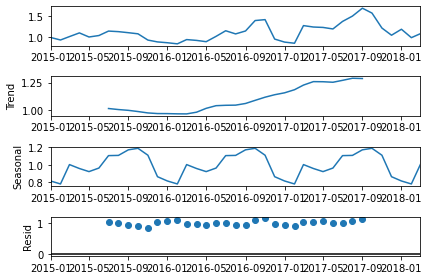

In [ ]:
decompose_con = df_con_price.set_index('ds')

decompose_con
decompose_con_price = seasonal_decompose(decompose_con, model='multiplicative')

plt.figure(figsize=(15,8))
decompose_con_price.plot()


plt.show()

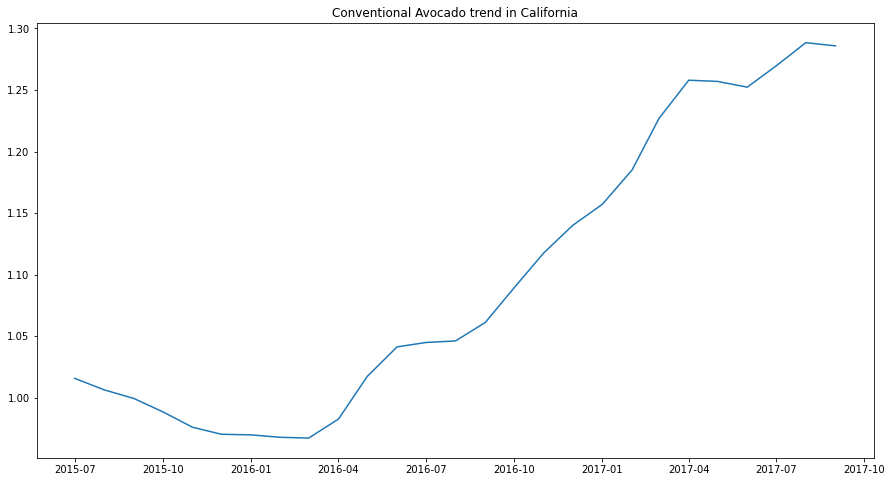

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(decompose_con_price.trend)
plt.title("Conventional Avocado trend in California")
plt.show()

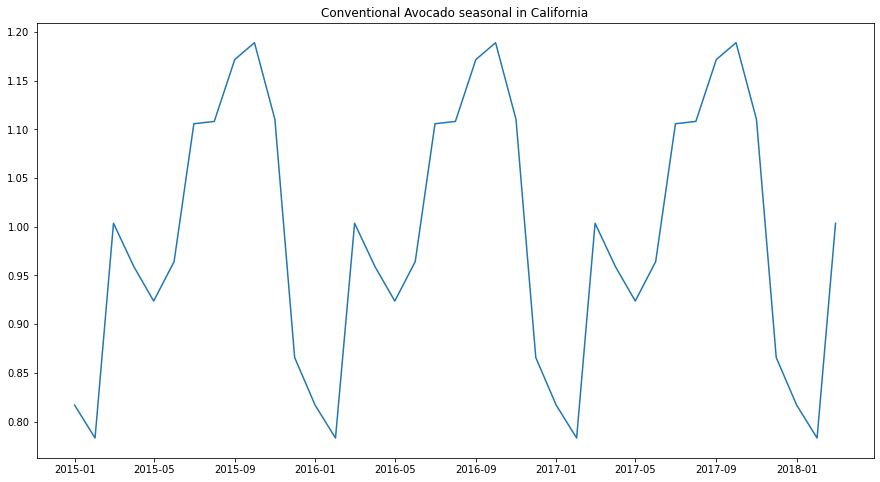

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(decompose_con_price.seasonal)
plt.title("Conventional Avocado seasonal in California")
plt.show()

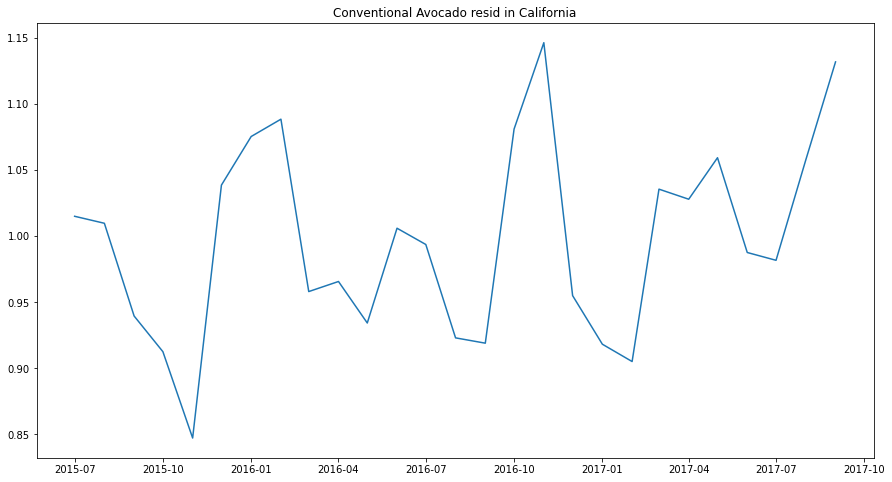

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(decompose_con_price.resid)
plt.title("Conventional Avocado resid in California")
plt.show()

## Kết luận:

  Trend có tính đi lên nhưng mang tính non-linear, thấy rõ tính seasonal, Residual cho thấy có khoảng từ 0.85 đến 1.15

# Train Test Split

In [ ]:
train = df_con_price.iloc[:-10, :]
train

,ds,y
0,2015-01-01,0.9825
1,2015-02-01,0.9200
2,2015-03-01,1.0040
3,2015-04-01,1.0950
4,2015-05-01,0.9940
5,2015-06-01,1.0300
6,2015-07-01,1.1400
7,2015-08-01,1.1260
8,2015-09-01,1.1000
9,2015-10-01,1.0725


In [ ]:
test = df_con_price.iloc[-10:, :]
test

,ds,y
29,2017-06-01,1.1925
30,2017-07-01,1.3780
31,2017-08-01,1.5100
32,2017-09-01,1.7050
33,2017-10-01,1.5840
34,2017-11-01,1.2150
35,2017-12-01,1.0380
36,2018-01-01,1.1850
37,2018-02-01,0.9775
38,2018-03-01,1.0750


# Part III) Make short predict

In [ ]:
model_con_price = Prophet(interval_width=0.95, yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model_con_price.fit(train)

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


# Cơ sở nào để bật các tham số cho function Prophet như trên?

Em chọn:

    interval_width parameter là vì nếu mà dự đoán càng về sau thì trend sẽ có dao động nên em lựa parameter là để có tỷ lệ linh hoạt trong dự đoán

    yearly_seasonality=True là vì em thấy nó có tính seasonal yearly

    daily_seasonality=False, weekly_seasonality=False vì em muố dự đoán dự trên tính seasonal yearly

In [ ]:
future_con_price = model_con_price.make_future_dataframe(periods=22, freq='M')

In [ ]:
future_con_price

,ds
0,2015-01-01
1,2015-02-01
2,2015-03-01
3,2015-04-01
4,2015-05-01
5,2015-06-01
6,2015-07-01
7,2015-08-01
8,2015-09-01
9,2015-10-01


In [ ]:
months = pd.date_range('2017-06-01', '2019-03-01', 
                       freq='MS').strftime("%Y-%m-%d").tolist()
months

['2017-06-01',
 '2017-07-01',
 '2017-08-01',
 '2017-09-01',
 '2017-10-01',
 '2017-11-01',
 '2017-12-01',
 '2018-01-01',
 '2018-02-01',
 '2018-03-01',
 '2018-04-01',
 '2018-05-01',
 '2018-06-01',
 '2018-07-01',
 '2018-08-01',
 '2018-09-01',
 '2018-10-01',
 '2018-11-01',
 '2018-12-01',
 '2019-01-01',
 '2019-02-01',
 '2019-03-01']

In [ ]:
future_con_price_1 = pd.DataFrame(months)
future_con_price_1.columns = ['ds']
future_con_price_1['ds'] = pd.to_datetime(future_con_price_1['ds'])
future_con_price_1

,ds
0,2017-06-01
1,2017-07-01
2,2017-08-01
3,2017-09-01
4,2017-10-01
5,2017-11-01
6,2017-12-01
7,2018-01-01
8,2018-02-01
9,2018-03-01


In [ ]:
forecast_con_price = model_con_price.predict(future_con_price_1)

In [ ]:
forecast_con_price

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-06-01,1.354731,1.261489,1.366580,1.351218,1.358912,-0.038100,-0.038100,-0.038100,-0.038100,-0.038100,-0.038100,0.0,0.0,0.0,1.316632
1,2017-07-01,1.380733,1.402163,1.510962,1.369952,1.391681,0.075779,0.075779,0.075779,0.075779,0.075779,0.075779,0.0,0.0,0.0,1.456511
2,2017-08-01,1.407601,1.358773,1.471001,1.388269,1.427828,0.007224,0.007224,0.007224,0.007224,0.007224,0.007224,0.0,0.0,0.0,1.414824
3,2017-09-01,1.434469,1.412373,1.533989,1.403595,1.465460,0.038009,0.038009,0.038009,0.038009,0.038009,0.038009,0.0,0.0,0.0,1.472478
4,2017-10-01,1.460470,1.581521,1.712523,1.419959,1.502535,0.188423,0.188423,0.188423,0.188423,0.188423,0.188423,0.0,0.0,0.0,1.648892
5,2017-11-01,1.487338,1.560654,1.698607,1.433958,1.540694,0.138387,0.138387,0.138387,0.138387,0.138387,0.138387,0.0,0.0,0.0,1.625725
6,2017-12-01,1.513339,1.215471,1.385459,1.448586,1.576456,-0.207079,-0.207079,-0.207079,-0.207079,-0.207079,-0.207079,0.0,0.0,0.0,1.306260
7,2018-01-01,1.540207,1.170828,1.359720,1.462316,1.616559,-0.273490,-0.273490,-0.273490,-0.273490,-0.273490,-0.273490,0.0,0.0,0.0,1.266716
8,2018-02-01,1.567075,1.151401,1.361949,1.473261,1.658660,-0.309428,-0.309428,-0.309428,-0.309428,-0.309428,-0.309428,0.0,0.0,0.0,1.257647
9,2018-03-01,1.591343,1.363146,1.605113,1.485302,1.696795,-0.110062,-0.110062,-0.110062,-0.110062,-0.110062,-0.110062,0.0,0.0,0.0,1.481281


In [ ]:
forecast_con_price[['ds', 'yhat']].head(10)

,ds,yhat
0,2017-06-01,1.316632
1,2017-07-01,1.456511
2,2017-08-01,1.414824
3,2017-09-01,1.472478
4,2017-10-01,1.648892
5,2017-11-01,1.625725
6,2017-12-01,1.306260
7,2018-01-01,1.266716
8,2018-02-01,1.257647
9,2018-03-01,1.481281


# Part IV) Evaluating model

In [ ]:
y_test = test['y'].values
y_pred = forecast_con_price['yhat'].values[:10]

mea_p = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mea_p)


MAE: 0.204


In [ ]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print('MAPE: %.3f' % mape)

MAPE: 0.173


In [ ]:
rmse_p = sqrt(mean_absolute_error(y_test, y_pred))
print('RMSE: %.3f' % rmse_p)

RMSE: 0.452


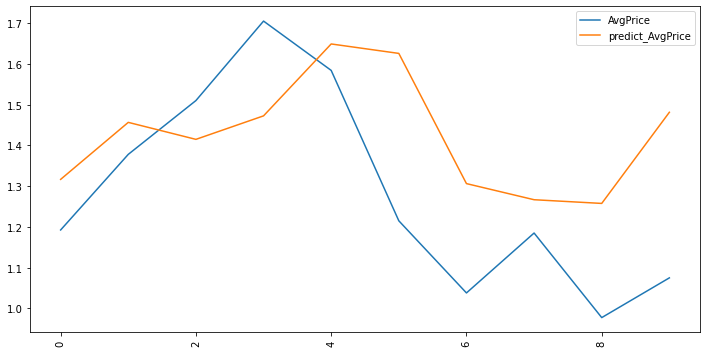

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="AvgPrice")
plt.plot(y_pred, label="predict_AvgPrice")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

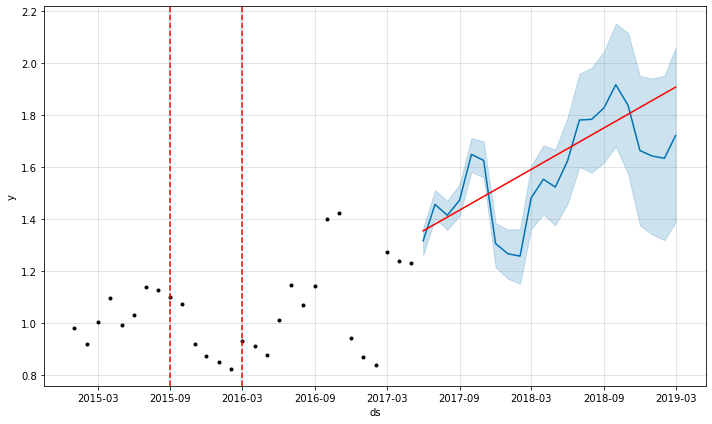

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = model_con_price.plot(forecast_con_price)
fig.show()

a= add_changepoints_to_plot(fig.gca(), model_con_price, forecast_con_price)

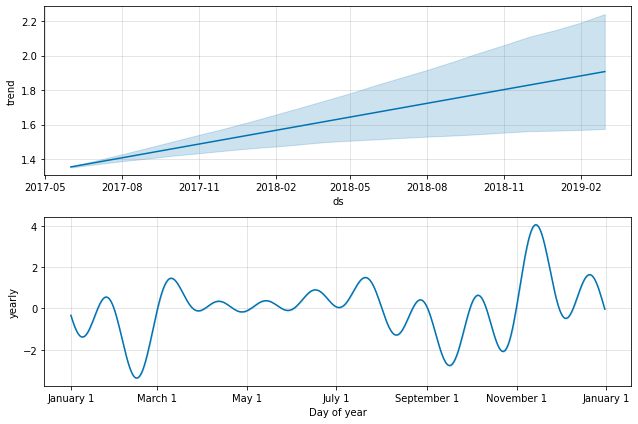

In [ ]:
fig = model_con_price.plot_components(forecast_con_price)
fig.show()

In [ ]:
forecast_con_price[['ds', 'yhat']].head(12)

,ds,yhat
0,2017-06-01,1.316632
1,2017-07-01,1.456511
2,2017-08-01,1.414824
3,2017-09-01,1.472478
4,2017-10-01,1.648892
5,2017-11-01,1.625725
6,2017-12-01,1.306260
7,2018-01-01,1.266716
8,2018-02-01,1.257647
9,2018-03-01,1.481281


# Part V) Make long predict

In [ ]:
from pandas._libs.tslibs import period
long_model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
long_model.fit(train)
long_future = long_model.make_future_dataframe(periods=12*5, freq='M')

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


In [ ]:
long_forecast = long_model.predict(long_future)

In [ ]:
long_forecast[['ds', 'trend', ]].tail(12)

,ds,trend
77,2021-05-31,2.620124
78,2021-06-30,2.646126
79,2021-07-31,2.672994
80,2021-08-31,2.699861
81,2021-09-30,2.725863
82,2021-10-31,2.752731
83,2021-11-30,2.778732
84,2021-12-31,2.805600
85,2022-01-31,2.832468
86,2022-02-28,2.856736


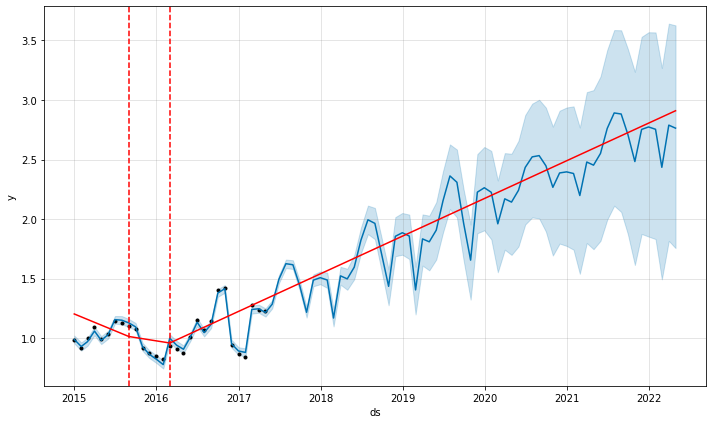

In [ ]:

fig_long = long_model.plot(long_forecast)
fig_long.show()

a_long= add_changepoints_to_plot(fig_long.gca(), long_model, long_forecast)

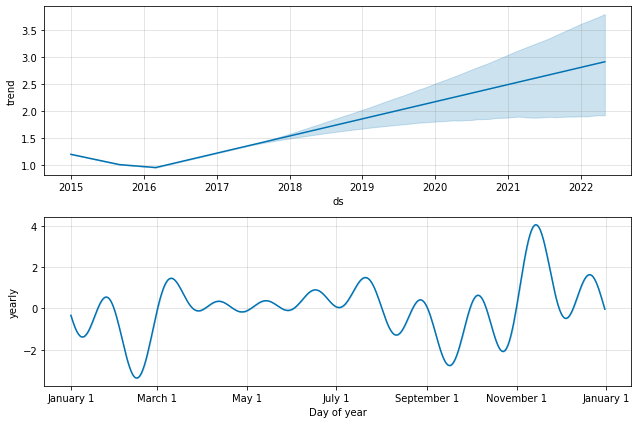

In [ ]:
fig_long = long_model.plot_components(long_forecast)
fig_long.show()

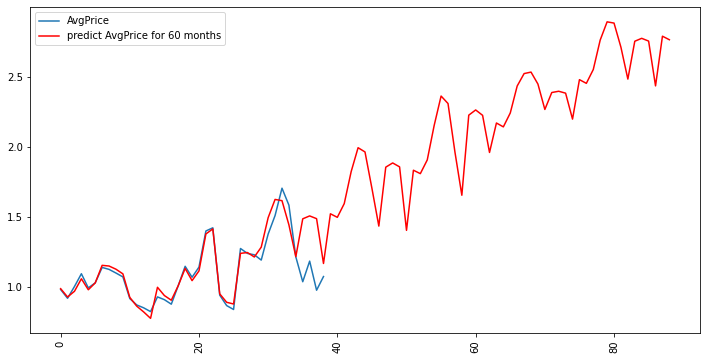

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_con_price['y'], label="AvgPrice")
plt.plot(long_forecast['yhat'], label="predict AvgPrice for 60 months", color ='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

# Kết luận:

    Sự giống nhau ở dự đoán ngắn hạn:

        Trend đi lên 
        
        Tính seasonal vào các tháng của năm

        Tính seasonal ít nhất vào tháng 3 đến tháng 6

        Có 2 change point vào 2015/9 và 2016/3 

    Sự khác nhau:

        Khảng cách giữa upper và lower của trend tăng có sự khác nhau:

            - Dự đoán ngắn: từ tháng 2/2018

            - Dự đoán dài: năm 2019 

        Khảng cách giữa upper và lower của dự đoán tăng có sự khác nhau:

            - Dự đoán ngắn: từ tháng 3/2018

            - Dự đoán dài: năm 2020


# Thích hợp để đầu tư sản xuất và dài hạng vào thị trường. Dự đoán vẫn chính xác ít nhất trước năm 2020

# Ngoài facebook prophet còn có thuật toán nào dành cho việc dự đoán time series có thể thử ở đây hay không? Hãy thực hiện và so sánh kết quả.

### Em sẽ sử dụng phép toán Autoregression để so sánh

In [ ]:
decompose_con

,y
ds,
2015-01-01,0.9825
2015-02-01,0.9200
2015-03-01,1.0040
2015-04-01,1.0950
2015-05-01,0.9940
2015-06-01,1.0300
2015-07-01,1.1400
2015-08-01,1.1260
2015-09-01,1.1000


In [ ]:
len(decompose_con)

39

In [ ]:
X_tr_AR = decompose_con.query('ds <= "2017-06-01"')
X_te_AR = decompose_con.query('ds >= "2017-06-01"')

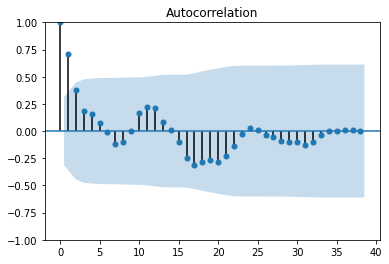

In [ ]:

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(decompose_con, lags=38)
plt.show()



# Training Autoregression with lags =1

In [ ]:
from statsmodels.tsa.ar_model import AutoReg


In [ ]:
model_lag1 = AutoReg(X_tr_AR, lags= 1).fit()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
pred_lag1 = model_lag1.predict(start=len(X_tr_AR), end=len(X_tr_AR)+len(X_te_AR)-1, dynamic=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [ ]:
y_test_lag1 = X_te_AR['y'].values
y_pred_lag1 = pred_lag1.values

mea_p_AR1 = mean_absolute_error(y_test_lag1, y_pred_lag1)
print('MAE: %.3f' % mea_p_AR1)


MAE: 0.229


In [ ]:
mape_AR1 = mean_absolute_percentage_error(y_test_lag1, y_pred_lag1)
print('MAPE: %.3f' % mape_AR1)

MAPE: 0.157


In [ ]:
rmse_p_AR1 = sqrt(mean_absolute_error(y_test_lag1, y_pred_lag1))
print('RMSE: %.3f' % rmse_p_AR1)

RMSE: 0.478


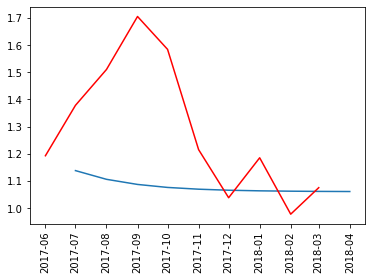

In [ ]:
plt.plot(pred_lag1)
plt.plot(X_te_AR, color = 'red')
plt.xticks(rotation='vertical')
plt.show()

# Showing the MAE and plot of all the possible lags

In [ ]:
p_r=range(0, 15)

In [ ]:
y_test_AR = X_te_AR['y'].values


In [ ]:
mae=[]
order1=[]

In [ ]:
for p in p_r:
  try:
        model = AutoReg(X_tr_AR, lags= p).fit()
        pred = model.predict(start=len(X_tr_AR), end=len(X_tr_AR)+len(X_te_AR)-1, dynamic=False)
        error = mean_absolute_error(y_test_AR, pred)
        order1.append(p)
        mae.append(p)
        mae.append(error)

  except:
       continue

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain t

In [ ]:
def Convert(lst):
    res_dct = {lst[i]: lst[i + 1] for i in range(0, len(lst), 2)}
    return res_dct

In [ ]:
dict_rmse = Convert(mae)
dict_rmse

{0: 0.2542900000000001,
 1: 0.22893700866518668,
 2: 0.24943981946830532,
 3: 0.250116700434829,
 4: 0.2368460352381653,
 5: 0.24536760074854694,
 6: 0.24714599274106366,
 7: 0.24722208869366996,
 8: 0.28599359625054765,
 9: 0.46115957676167474,
 10: 0.5545905831676912,
 11: 0.39586729778803736,
 12: 2.1147745923272927,
 13: 5.564126893585277,
 14: 35.4027666065496}

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


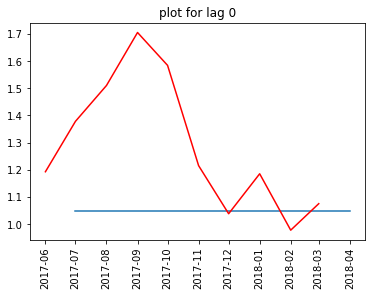

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


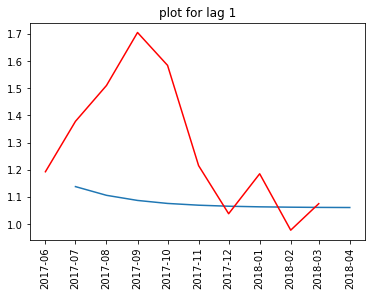

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


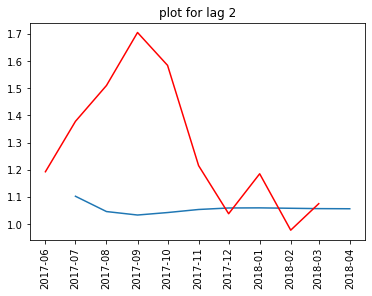

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


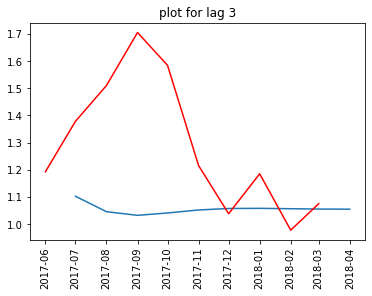

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


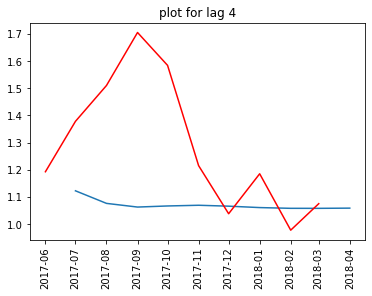

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


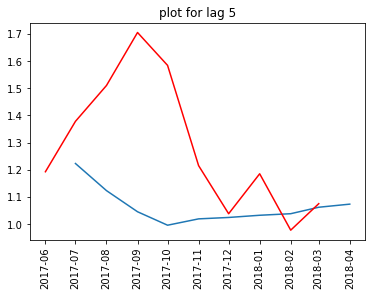

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


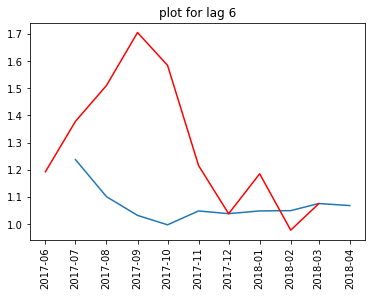

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


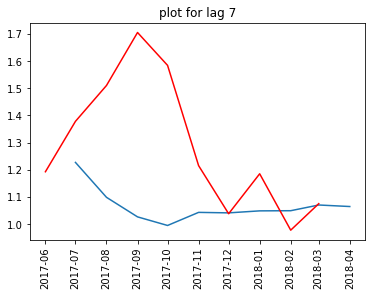

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


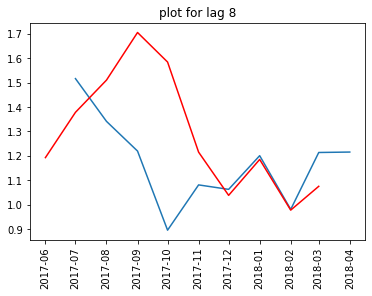

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


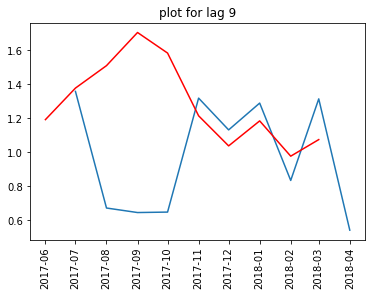

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


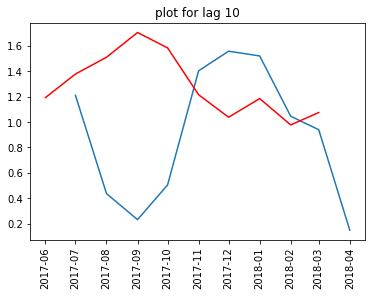

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


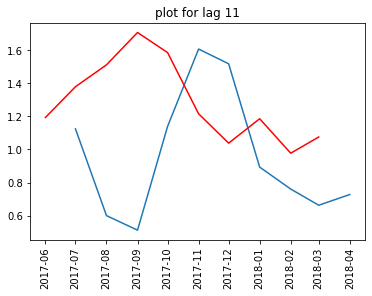

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


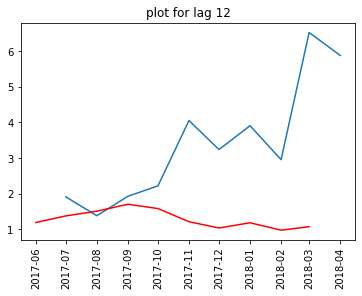

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


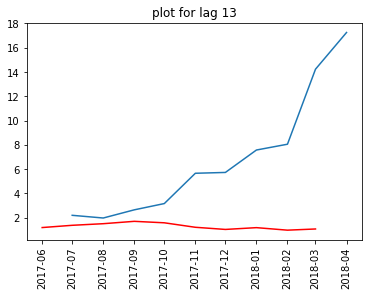

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


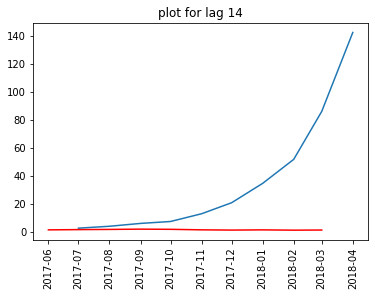

In [ ]:
for p in p_r:
  try:
        model = AutoReg(X_tr_AR, lags= p).fit()
        pred = model.predict(start=len(X_tr_AR), end=len(X_tr_AR)+len(X_te_AR)-1, dynamic=False)
        plt.plot(pred)
        plt.plot(X_te_AR, color = 'red')
        plt.title("plot for lag %s" % p)
        plt.xticks(rotation='vertical')

        plt.show()

  except:
       continue

# Nhận Xét:

    trong các kết quả tuy lag = 1 có mae thấp nhất nhưng plot cho thấy không phù hợp nhất

    Nhưng lag = 8 thì lại cho plot thích hợp nhất nhưng mae có tăng nhưng ít 

## Nên em sẽ lựa cho lag =8 sẽ là kết quả so sánh cuối

# Train AutoRegresion on the lag = 8 

In [ ]:
model_2 = AutoReg(X_tr_AR, lags= 8).fit()
model_2.summary()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


'\nThe model specification cannot be estimated. \nThe model contains 16 regressors (1 trend, 0 seasonal, 15 lags) but after adjustment for hold_back and creation of the lags, \nthere are only 15 data points available to estimate parameters.\n'

In [ ]:
predictions = model_2.predict(start=len(X_tr_AR), end=len(X_tr_AR)+len(X_te_AR)-1, dynamic=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [ ]:
y_test_AR = X_te_AR['y'].values
y_pred_AR = predictions.values

mea_p_AR = mean_absolute_error(y_test_AR, y_pred_AR)
print('MAE: %.3f' % mea_p_AR)


MAE: 0.286


In [ ]:
mape_AR = mean_absolute_percentage_error(y_test_AR, y_pred_AR)
print('MAPE: %.3f' % mape_AR)

MAPE: 0.211


In [ ]:
rmse_p_AR = sqrt(mean_absolute_error(y_test_AR, y_pred_AR))
print('RMSE: %.3f' % rmse_p_AR)

RMSE: 0.535


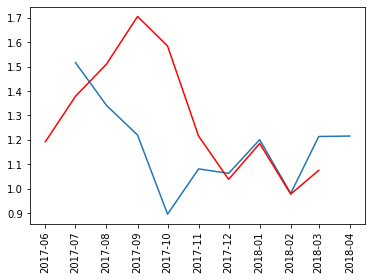

In [ ]:
plt.plot(predictions)
plt.plot(X_te_AR, color = 'red')
plt.xticks(rotation='vertical')
plt.show()

# Nhận xét:

    Về lag = 8 chỉ số mae sẽ hơi cao nhưng sẽ phù hợp hơn về plot

# Tổng kết:

    Kết quả chung là có xu hướng đi lên nên rất thích hợp cho tăng sản lượng bán

    Ở tất cả các thông số Prophet đều tốt hơn Autoregression trên tất cả các tunning

In [ ]:
test_result = {'tên thuật toán':['Prophet', 'Autoregression_lag_1', 'Autoregression_lag_8'],
               'MAE':[mea_p, mea_p_AR1, mea_p_AR],
               'MAPE':[mape, mape_AR1, mape_AR],
               'RMSE':[rmse_p, rmse_p_AR1, rmse_p_AR],}
df_result = pd.DataFrame(test_result)
df_result

,tên thuật toán,MAE,MAPE,RMSE
0,Prophet,0.204236,0.173142,0.451925
1,Autoregression_lag_1,0.228937,0.156750,0.478474
2,Autoregression_lag_8,0.285994,0.210987,0.534784
